In [1]:
import sys
sys.path.append("./source")
from lmmNet import lmmNet

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import tensorflow as tf

# Data Cleaning

Tasks:
- subset only the right strains from the metabolite table
- subset only the relevant molecular species from metabolite table
- impute missing values
- subset only the relevant strains from the proteomic table
- perform QC on the proteomic data
- subset only the relevant molecular species from the proteomic table
- join the proteomic and metabolomic table

In [2]:
data_folder = 'data'
metabolite_file_name = os.path.join(data_folder, 'time_series_metabolomics.csv')
mdf = pd.read_csv(metabolite_file_name)
print("Shape of metabolomics data: ", mdf.shape)
print("Strain list: ", mdf['Strain'].unique())
print("Column names: ", mdf.columns)

Shape of metabolomics data:  (126, 91)
Strain list:  ['I1' 'I2' 'I3' 'B1' 'B2' 'L1' 'L2' 'L3' 'DH1']
Column names:  Index(['Hour', 'Strain', 'Sample', 'OD600', 'Intracellular volume / sample',
       'Glucose g/L', 'Pyruvate g/L', 'Succinate g/L', 'Lactate g/L',
       'Formate g/L', 'Acetate g/L', 'Isopentenol g/L', 'Bisabolene g/L',
       'Limonene g/L', 'Acetoacetyl-coA (uM)', 'HMG-CoA (uM)',
       'Intracellular Mevalonate (uM)', 'Mev-P (uM)', 'IPP/DMAPP (uM)',
       'IP (uM)', 'GPP (uM)', 'FPP (uM)', 'AMP (uM)', 'ADP (uM)', 'ATP (uM)',
       'NAD (uM)', 'NADP (uM)', 'Acetyl-CoA (uM)', 'Fru-1,6-BiP (uM)',
       '3-P Glycerate (uM)', 'PEP (uM)', 'Pyruvate (uM)', 'lactate (uM)',
       'fumarate (uM)', 'succinate (uM)', 'oxaloacetate (uM)', 'malate (uM)',
       'oxoglutarate (uM)', 'cis-aconitate (uM)', 'citrate (uM)',
       'isocitrate (uM)', 'Glyoxylate (uM)', 'Glycolate (uM)', 'DXP', 'MEP',
       'HDMAPP', 'ME-cPP', 'CDP-ME', 'Glycine', 'Alanine', 'Serine', 'Proline',
    

In [3]:
# here we only want limonene strains
strains, training_strains, test_strains = ['L1','L2','L3'], ['L1','L3'], ['L2']
# these are the metabolic species to be predicted (incl. limonene)
targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Limonene g/L']

mdf = mdf.loc[mdf['Strain'].isin(strains)]
display(mdf[['Strain', 'Hour'] + targets])

,Strain,Hour,Acetyl-CoA (uM),HMG-CoA (uM),Intracellular Mevalonate (uM),Mev-P (uM),IPP/DMAPP (uM),Limonene g/L
70,L1,0,0.386459,0.002562,0.003715,0.000000,0.071364,0.000000
71,L1,2,NaN,NaN,NaN,NaN,NaN,NaN
72,L1,4,0.815275,0.203158,0.161369,0.516691,0.721004,0.002417
73,L1,6,NaN,NaN,NaN,NaN,NaN,NaN
74,L1,8,NaN,NaN,0.170785,0.756921,1.491663,0.007934
75,L1,10,NaN,NaN,NaN,NaN,NaN,NaN
76,L1,12,0.488733,0.231160,0.168154,0.804748,1.508219,0.014846
77,L1,16,NaN,NaN,NaN,NaN,NaN,NaN
78,L1,18,0.317210,0.190574,0.142823,2.333130,2.774149,0.018471
79,L1,20,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# select only relevant columns
outputs = ['Acetyl-CoA (uM)','Acetyl-CoA extracellular (uM)',
                   'Acetoacetyl-coA (uM)','Acetoacetyl-CoA extracellular (uM)',
                   'HMG-CoA (uM)','HMG-CoA extracellular (uM)',
                   'Intracellular Mevalonate (uM)','MEVALONATE extracellular (uM)',
                   'Mev-P (uM)','MEV-P extracellular (uM)',
                   'IPP/DMAPP (uM)','IPP/DMAPP extracellular (uM)',
                   'GPP (uM)','GPP extracellular (uM)',
                   'Limonene g/L','ATP (uM)','OD600','NAD (uM)','NADP (uM)',
                   'Acetate g/L','Pyruvate g/L','citrate (uM)','Isopentenol g/L']

In [5]:
# now we must interpolate missing values

mdf = mdf.reset_index()
mdf = mdf.interpolate(method ='linear', limit_direction ='forward')
mdf = mdf[['Strain','Hour'] + outputs].pivot_table(mdf[['Strain','Hour'] + outputs],index=['Strain','Hour'],aggfunc=np.sum)
display(mdf[targets])

Acetyl-CoA (uM)  HMG-CoA (uM)  Intracellular Mevalonate (uM)  \
Strain Hour                                                                 
L1     0            0.386459      0.002562                       0.003715   
       2            0.600867      0.102860                       0.082542   
       4            0.815275      0.203158                       0.161369   
       6            0.733639      0.210158                       0.166077   
       8            0.652004      0.217159                       0.170785   
       10           0.570369      0.224159                       0.169469   
       12           0.488733      0.231160                       0.168154   
       16           0.402971      0.210867                       0.155489   
       18           0.317210      0.190574                       0.142823   
       20           0.277733      0.189813                       0.161614   
       24           0.238256      0.189051                       0.180405   
       36           0.158098      0.148541                       0.089452   
       48           0.077939      0.108031                       0.068482   
       72           0.182149      0.057830                       0.069763   
L2     0            0.286359      0.007628                       0.892763   
       2            0.314098      0.024570                       1.772122   
       4            0.341838      0.041512                       2.651481   
       6            0.316095      0.045943                       2.969243   
       8            0.290352      0.050373                       3.287004   
       10           0.264609      0.054803                       3.687173   
       12           0.238866      0.059233                       4.087343   
       16           0.212017      0.049501                       3.722331   
       18           0.185168      0.039769                       3.357319   
       20           0.163885      0.030129                       3.975827   
       24           0.142602      0.020489                       4.594335   
       36           0.112074      0.013672                       5.166683   
       48           0.081545      0.006856                       4.371739   
       72           0.164040      0.004976                       5.462721   
L3     0            0.246535      0.003096                       0.036670   
       2            0.301730      0.006188                       0.368531   
       4            0.356924      0.009279                       0.700392   
       6            0.361576      0.010647                       0.774576   
       8            0.366228      0.012015                       0.848760   
       10           0.370879      0.013382                       0.896955   
       12           0.375531      0.014750                       0.945150   
       16           0.397997      0.011864                       0.968477   
       18           0.420463      0.008978                       0.991804   
       20           0.333603      0.009342                       1.244933   
       24           0.246743      0.009705                       1.498061   
       36           0.205029      0.004853                       0.931822   
       48           0.163314      0.000000                       1.213345   
       72           0.163314      0.000000                       1.369915   

             Mev-P (uM)  IPP/DMAPP (uM)  Limonene g/L  
Strain Hour                                            
L1     0       0.000000        0.071364      0.000000  
       2       0.258346        0.396184      0.001209  
       4       0.516691        0.721004      0.002417  
       6       0.636806        1.106333      0.005176  
       8       0.756921        1.491663      0.007934  
       10      0.780834        1.499941      0.011390  
       12      0.804748        1.508219      0.014846  
       16      1.568939        2.141184      0.016658  
       18      2.333130        2.774149      0.018471  
       2

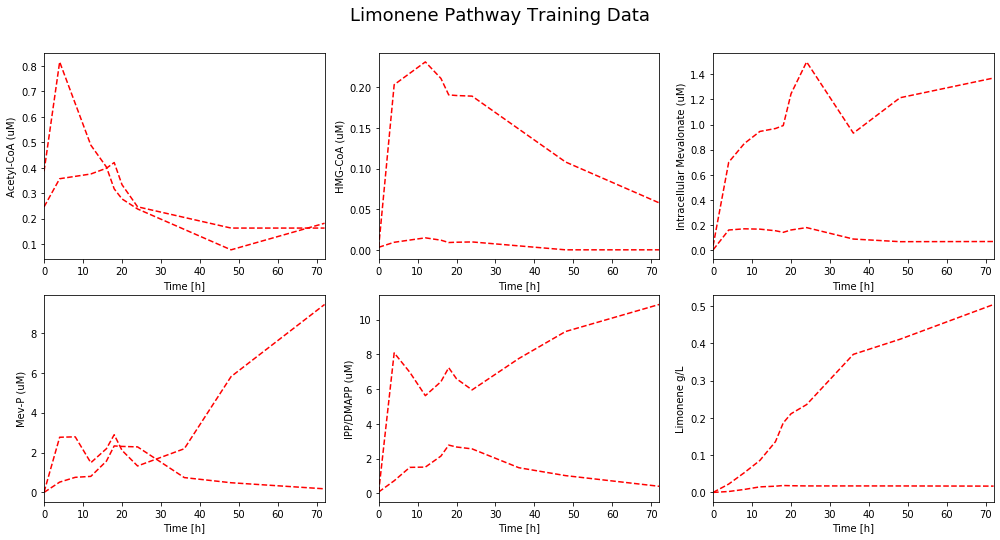

In [6]:
# now let's plot the pre-processed training data

plt.figure(figsize=(14, 8))
for i, target in enumerate(targets):
    plt.subplot(2, 3, i + 1)
    for strain in training_strains:
        strain_df = mdf.loc[(strain,slice(None))]
        
        # handle missing data
        y = strain_df[target].tolist()
        X = strain_df.reset_index()['Hour'].tolist()
        #X,y = remove_NaN(strain_df.reset_index()['Time'].tolist(),strain_df[target].tolist())
        #trainInterpFun = interp1d(X,y) #create an interpolation function
        #actual_data = savgol_filter(trainInterpFun(times), 7, 2)
        train_line, = plt.plot(X, y,'r--')
    plt.ylabel(target)
    plt.xlabel('Time [h]')
    plt.xlim([0,72])
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.subplots_adjust(bottom=0.12)
plt.suptitle('Limonene Pathway Training Data', fontsize=18)
plt.show()

In [7]:
# now we read and examine the protein data
protein_file_name = os.path.join(data_folder, 'time_series_proteomics.csv')
pdf = pd.read_csv(protein_file_name)
print("Shape of proteomics data: ", pdf.shape)
print("Strain list: ", pdf['Strain'].unique())
print("Column names: ", pdf.columns)
print("Protein list: ", pdf['Protein'].unique())

Shape of proteomics data:  (13439, 23)
Strain list:  ['I1' 'I2' 'I3' 'B1' 'B2' 'L1' 'L2' 'L3' 'DH1']
Column names:  Index(['Sample Name', 'Hour', 'Organism', 'Strain', 'Replicate', 'Protein',
       'Protein name', 'Pathway', 'Peptide', 'PeptideArea',
       'PeptideCorrectedArea', 'PeptideCorrectedArea Normalized to AmpR',
       'PeptideCorrectedArea Normalized to Cam',
       'PeptideCorrectedArea Normalized to BSA', 'ProteinArea',
       'ProteinArea Normalized to AmpR', 'ProteinArea Normalized to Cam',
       'ProteinArea Normalized to BSA', 'PrecursorMz', 'PrecursorCharge',
       'RetentionTime', 'Background', 'PeakRank'],
      dtype='object')
Protein list:  ['AtoB' 'Bisabolene' 'HMGR' 'HMGS' 'Idi' 'IspA' 'Limonene Synthase' 'MK'
 'NudB' 'PMD' 'PMK' '6PGD' 'FRDA' 'CAPP' 'LACI' 'FUMC' 'K6PF2' 'DHSB'
 'FDHF' 'IDH' 'PFLB' 'ACKA' 'ENO' 'G6PI' 'K6PF1' 'PGK' 'RPIA' 'SUCC'
 'TPIS' 'TALA' 'TALB' 'FRDC' 'FRDD' 'F16PA' 'G3P1' 'GLPX' 'PTA' 'DLDH'
 'ADHE' 'HYCB' 'ALF' 'CISY' 'FUMA' 'DHSA' 

In [8]:
pdf.loc[pdf['Hour'].isin(['72C'])]

,Sample Name,Hour,Organism,Strain,Replicate,Protein,Protein name,Pathway,Peptide,PeptideArea,...,PeptideCorrectedArea Normalized to BSA,ProteinArea,ProteinArea Normalized to AmpR,ProteinArea Normalized to Cam,ProteinArea Normalized to BSA,PrecursorMz,PrecursorCharge,RetentionTime,Background,PeakRank
1359,10,72C,Escherichia coli,I1,10,AtoB,NaN,Mevalonate Pathway,LGDGQVYDVILR,1819374.0,...,5.840050,1417820.5,14.7325,4.8890,4.5547,0,0,0,1460,0
1360,10,72C,Escherichia coli,I1,10,AtoB,NaN,Mevalonate Pathway,TFVFSQDEFPK,1019731.0,...,3.269448,1417820.5,14.7325,4.8890,4.5547,0,0,0,2004,0
1361,10,72C,NaN,I1,10,Bisabolene,NaN,Mevalonate Pathway,ASQLAFPGENILDEAK,1514.0,...,0.004864,1250.5,0.0130,0.0043,0.0040,0,0,0,0,0
1362,10,72C,NaN,I1,10,Bisabolene,NaN,Mevalonate Pathway,YNVSPAIFDNFK,987.0,...,0.003171,1250.5,0.0130,0.0043,0.0040,0,0,0,0,0
1363,10,72C,Saccharomyces cerevisiae,I1,10,HMGR,NaN,Mevalonate Pathway,SDVSALVELNIAK,23069.0,...,0.072307,48458.0,0.5035,0.1671,0.1557,0,0,0,561,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12075,80,72C,NaN,L3,80,AMPR,NaN,Antibiotic Marker,SALPAGWFIADK,158960.0,...,0.476792,137900.5,1.0000,0.4247,0.4160,0,0,0,899,0
12076,80,72C,NaN,L3,80,AMPR,NaN,Antibiotic Marker,VGYIELDLNSGK,118436.0,...,0.355164,137900.5,1.0000,0.4247,0.4160,0,0,0,696,0
12077,80,72C,NaN,L3,80,Cam,NaN,Antibiotic Marker,FYPAFIHILAR,353698.0,...,1.066933,324670.0,2.3544,1.0000,0.9794,0,0,0,0,0
12078,80,72C,NaN,L3,80,Cam,NaN,Antibiotic Marker,ITGYTTVDISQWHR,298510.0,...,0.891807,324670.0,2.3544,1.0000,0.9794,0,0,0,2868,0


In [9]:
pdf = pdf.loc[pdf['Strain'].isin(strains)] # subset only relevant strains
pdf = pdf.loc[~pdf['Hour'].isin(['72C'])] # QC
pdf['Hour'] = pdf['Hour'].astype('float32')
display(pdf)

,Sample Name,Hour,Organism,Strain,Replicate,Protein,Protein name,Pathway,Peptide,PeptideArea,...,PeptideCorrectedArea Normalized to BSA,ProteinArea,ProteinArea Normalized to AmpR,ProteinArea Normalized to Cam,ProteinArea Normalized to BSA,PrecursorMz,PrecursorCharge,RetentionTime,Background,PeakRank
7550,51,0.0,Escherichia coli,L1,51,AtoB,NaN,Mevalonate Pathway,LGDGQVYDVILR,6177.0,...,0.020394,4104.5,0.0229,0.0145,0.0136,0,0,0,0,0
7551,51,0.0,Escherichia coli,L1,51,AtoB,NaN,Mevalonate Pathway,TFVFSQDEFPK,2032.0,...,0.006709,4104.5,0.0229,0.0145,0.0136,0,0,0,0,0
7552,51,0.0,NaN,L1,51,Bisabolene,NaN,Mevalonate Pathway,ASQLAFPGENILDEAK,2595.0,...,0.008568,1946.5,0.0109,0.0069,0.0064,0,0,0,0,0
7553,51,0.0,NaN,L1,51,Bisabolene,NaN,Mevalonate Pathway,YNVSPAIFDNFK,1298.0,...,0.004286,1946.5,0.0109,0.0069,0.0064,0,0,0,0,0
7554,51,0.0,Saccharomyces cerevisiae,L1,51,HMGR,NaN,Mevalonate Pathway,SDVSALVELNIAK,23223.0,...,0.075007,30588.0,0.1709,0.1079,0.1010,0,0,0,505,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11924,79,72.0,NaN,L3,79,AMPR,NaN,Antibiotic Marker,SALPAGWFIADK,171979.0,...,0.544081,141092.0,1.0000,0.3847,0.4473,0,0,0,346,0
11925,79,72.0,NaN,L3,79,AMPR,NaN,Antibiotic Marker,VGYIELDLNSGK,113026.0,...,0.350449,141092.0,1.0000,0.3847,0.4473,0,0,0,2475,0
11926,79,72.0,NaN,L3,79,Cam,NaN,Antibiotic Marker,FYPAFIHILAR,426382.0,...,1.351641,366798.0,2.5997,1.0000,1.1628,0,0,0,0,0
11927,79,72.0,NaN,L3,79,Cam,NaN,Antibiotic Marker,ITGYTTVDISQWHR,308652.0,...,0.973876,366798.0,2.5997,1.0000,1.1628,0,0,0,1438,0


In [10]:
columns = ['Strain','Hour','Protein','ProteinArea'] # relevant columns in the proteomic table
pdf = pdf[columns].pivot_table(pdf[columns],index=['Strain','Hour'],columns='Protein',aggfunc=np.sum)
display(pdf) # this is now a multi-index dataframe

ProteinArea                                                  \
Protein            6PGD      ACKA     ACON1     ACON2    ACSA      ADHE   
Strain Hour                                                               
L1     0.0     646648.0  106700.0   23726.0  414333.0  1757.0  613848.0   
       4.0     708104.0   55363.0   72068.0  699237.0  4083.0  467813.0   
       8.0     689989.0   47908.0  108428.0  607602.0  3725.0  589579.0   
       12.0    668346.0   44104.0  106524.0  456901.0  4185.0  585248.0   
       18.0    881436.0   56261.0  137354.0  461447.0  3940.0  740942.0   
       24.0    680600.0   41163.0  101695.0  330333.0  3332.0  582901.0   
       36.0    737104.0   42860.0  133172.0  411334.0  4606.0  650471.0   
       48.0    687424.0   38669.0  129030.0  344906.0  4037.0  634372.0   
       72.0    682588.0   36133.0  130064.0  327990.0  2439.0  623072.0   
L2     0.0     781992.0   92353.0   24754.0  445979.0  2356.0  428360.0   
       4.0     284991.0   36940.0   12773.0  284185.0  1507.0  235425.0   
       8.0     333634.0   43639.0   16966.0  322410.0  1935.0  277068.0   
       12.0    251410.0   30217.0   15321.0  237327.0  1821.0  223401.0   
       18.0    278723.0   30477.0   22965.0  192974.0  3054.0  237397.0   
       24.0    319023.0   26731.0   31365.0  197897.0  1903.0  240938.0   
       36.0    294652.0   26381.0   34507.0  146038.0  3050.0  238842.0   
       48.0    297328.0   23055.0   46765.0  154781.0  2875.0  270569.0   
       72.0    321649.0   23053.0   68170.0  196469.0  2539.0  316818.0   
L3     0.0     651476.0  103104.0   15858.0  378422.0  2507.0  548433.0   
       4.0     552501.0   51248.0   58465.0  884546.0  2643.0  353890.0   
       8.0     571560.0   48023.0   83148.0  797831.0  3667.0  432232.0   
       12.0    597922.0   45924.0  106843.0  814140.0  2999.0  486091.0   
       18.0    571223.0   41180.0  102681.0  688661.0  3763.0  468098.0   
       24.0    603338.0   43574.0  117176.0  693847.0  4024.0  475903.0   
       36.0    569767.0   41898.0  113374.0  589606.0  3548.0  502538.0   
       48.0    567885.0   36411.0  118126.0  595590.0  2686.0  517772.0   
       72.0    489190.0   33843.0  109560.0  541126.0  2967.0  476504.0   

                                                       ...                    \
Protein           ALF      AMPR        AtoB       BSA  ...      RPIA    RPIB   
Strain Hour                                            ...                     
L1     0.0   432193.0  357905.0      8209.0  302877.0  ...  122478.0  2073.0   
       4.0   427401.0  385600.0   1484471.0  318329.0  ...  121892.0  3697.0   
       8.0   484531.0  349105.0   1614585.0  338928.0  ...  136362.0  5524.0   
       12.0  475813.0  328494.0   1560691.0  313419.0  ...  124679.0  3843.0   
       18.0  606497.0  400673.0   1937084.0  324917.0  ...  142964.0  3526.0   
       24.0  460776.0  333601.0   1477381.0  325876.0  ...  120789.0  4783.0   
       36.0  551577.0  309558.0   1772569.0  334351.0  ...  124335.0  4838.0   
       48.0  507003.0  241094.0   1653221.0  305596.0  ...  126075.0  3817.0   
       72.0  480220.0  158619.0   1302122.0  310060.0  ...  123507.0  2352.0   
L2     0.0   474145.0  680742.0   1268050.0  320445.0  ...  127535.0  4185.0   
       4.0   169732.0  300105.0  11694977.0  328796.0  ...   40971.0  1589.0   
       8.0   196674.0  294281.0  20400000.0  303624.0  ...   49845.0  3429.0   
       12.0  160388.0  171461.0  20400000.0  325911.0  ...   43528.0  2521.0   
       18.0  154599.0  121579.0  17725856.0  360596.0  ...   52639.0  3134.0   
       24.0  167558.0  117853.0  20000000.0  328970.0  ...   49553.0  2884.0   
       36.0  163164.0   93050.0  18090900.0  354634.0  ...   53610.0  1763.0   
       48.0  167987.0   94383.0  17057570.0  314434.0  ...   53127.0  2777.0   
       72.0  224320.0   75453.0  15361209.0  301478.0  ...   72269.0  3062.0   
L3     0.0   468114.0  393065.0     50439.0  281239.0  ...  100782.0  2023.0   
 

In [11]:
proteins = ['AtoB','HMGR','HMGS','MK','PMD','PMK','Idi','GPPS','Limonene Synthase','NudB'] # relevant proteins
proteins = [('ProteinArea',protein) for protein in proteins]
pdf = pdf[proteins]
print(pdf.columns)

MultiIndex([('ProteinArea',              'AtoB'),
            ('ProteinArea',              'HMGR'),
            ('ProteinArea',              'HMGS'),
            ('ProteinArea',                'MK'),
            ('ProteinArea',               'PMD'),
            ('ProteinArea',               'PMK'),
            ('ProteinArea',               'Idi'),
            ('ProteinArea',              'GPPS'),
            ('ProteinArea', 'Limonene Synthase'),
            ('ProteinArea',              'NudB')],
           names=[None, 'Protein'])


In [12]:
pdf.columns = pdf.columns.get_level_values(1)
display(pdf)

Protein            AtoB       HMGR        HMGS         MK        PMD  \
Strain Hour                                                            
L1     0.0       8209.0    68464.0     29238.0    19532.0   349263.0   
       4.0    1484471.0   223652.0    492929.0    50037.0   557136.0   
       8.0    1614585.0   204481.0    483006.0    51045.0   656509.0   
       12.0   1560691.0   181504.0    474976.0    53706.0   692486.0   
       18.0   1937084.0   218177.0    590173.0    66428.0   842557.0   
       24.0   1477381.0   177012.0    483653.0    53693.0   668706.0   
       36.0   1772569.0   184872.0    501223.0    55784.0   797741.0   
       48.0   1653221.0   175501.0    467626.0    54921.0   719763.0   
       72.0   1302122.0   143055.0    451549.0    51173.0   710718.0   
L2     0.0    1268050.0   975303.0   1814537.0    66644.0   222086.0   
       4.0   11694977.0  5552278.0  12874533.0   856518.0  1120042.0   
       8.0   20400000.0  8593167.0  23209717.0  1595060.0  2920532.0   
       12.0  20400000.0  7944106.0  22010089.0  1656186.0  3014555.0   
       18.0  17725856.0  6821902.0  18686861.0  1654815.0  3312130.0   
       24.0  20000000.0  6527289.0  18827893.0  1704014.0  3419861.0   
       36.0  18090900.0  5140768.0  15830407.0  1552782.0  3320835.0   
       48.0  17057570.0  4649280.0  13606759.0  1494543.0  3229677.0   
       72.0  15361209.0  4145041.0  10316009.0  1288346.0  2835588.0   
L3     0.0      50439.0   122581.0     76314.0    27218.0    92311.0   
       4.0    1243475.0   357869.0    792739.0   834097.0  1889751.0   
       8.0    1637580.0   441403.0   1025023.0  1111356.0  2881791.0   
       12.0   1751133.0   497937.0   1041544.0  1430725.0  3343904.0   
       18.0   1588690.0   435496.0    966447.0  1579868.0  3835400.0   
       24.0   1714324.0   455960.0   1032127.0  1872053.0  4266870.0   
       36.0   1651317.0   457905.0   1079484.0  2057900.0  4686725.0   
       48.0   1783767.0   461828.0   1086167.0  2168842.0  4928542.0   
       72.0   1651169.0   411109.0    981081.0  1919306.0  4782684.0   

Protein            PMK        Idi        GPPS  Limonene Synthase     NudB  
Strain Hour                                                                
L1     0.0     78129.0   678723.0      7934.0           233080.0  10827.0  
       4.0     32024.0   882715.0   1279279.0         14184519.0  48234.0  
       8.0     19615.0   995526.0   1242422.0         14914904.0  43116.0  
       12.0    19545.0   934538.0   1205546.0         13691535.0  40161.0  
       18.0    18964.0  1233368.0   1609621.0         16143199.0  59525.0  
       24.0    16031.0   885615.0   1279718.0         13275815.0  35031.0  
       36.0    23131.0  1025149.0   1270380.0         15309986.0  49631.0  
       48.0    16436.0   899851.0   1133490.0         13183372.0  40397.0  
       72.0    18571.0   875530.0    936997.0         12169879.0  29451.0  
L2     0.0     38871.0   992709.0    238334.0          1016183.0  13853.0  
       4.0    780656.0  1562460.0  11734492.0         15152786.0  35169.0  
       8.0   1230925.0  2730791.0  18687520.0         25800000.0  58942.0  
       12.0  1747295.0  2283673.0  15128321.0         21800000.0  51299.0  
       18.0  1897376.0  2084517.0  13543911.0         20800000.0  41562.0  
       24.0  2212389.0  2511286.0  15171025.0         19586312.0  53747.0  
       36.0  2094512.0  2200888.0  14993057.0         19665648.0  52512.0  
       48.0  2350300.0  1973428.0  17127800.0         20800000.0  47867.0  
       72.0  2454097.0  1670806.0  18437344.0         21400000.0  54072.0  
L3     0.0    211927.0   325994.0    297412.0           319950.0   4126.0  
       4.0    588087.0  2778685.0   4043845.0         11680415.0  31528.0  
       8.0    750621.0  3357679.0   3753584.0         13418025.0   9948.0  
       12.0   959681.0  3922590.0   3156798.0         14887581.0  47360.0  
       18.0  1043792.0  3962489.0   2710574.0         15278968.0  44980.0  
       24.0

In [13]:
# now we join the metabolic and proteomic table
all_df = pd.concat([pdf, mdf], axis=1)
all_df = all_df.interpolate(method ='linear', limit_direction ='forward')
train_df = all_df.loc[(training_strains,slice(None))]
test_df = all_df.loc[(test_strains,slice(None))]

display(train_df)

AtoB      HMGR       HMGS         MK        PMD        PMK  \
Strain Hour                                                                    
L1     0.0      8209.0   68464.0    29238.0    19532.0   349263.0    78129.0   
       2.0    746340.0  146058.0   261083.5    34784.5   453199.5    55076.5   
       4.0   1484471.0  223652.0   492929.0    50037.0   557136.0    32024.0   
       6.0   1549528.0  214066.5   487967.5    50541.0   606822.5    25819.5   
       8.0   1614585.0  204481.0   483006.0    51045.0   656509.0    19615.0   
       10.0  1587638.0  192992.5   478991.0    52375.5   674497.5    19580.0   
       12.0  1560691.0  181504.0   474976.0    53706.0   692486.0    19545.0   
       16.0  1748887.5  199840.5   532574.5    60067.0   767521.5    19254.5   
       18.0  1937084.0  218177.0   590173.0    66428.0   842557.0    18964.0   
       20.0  1707232.5  197594.5   536913.0    60060.5   755631.5    17497.5   
       24.0  1477381.0  177012.0   483653.0    53693.0   668706.0    16031.0   
       36.0  1772569.0  184872.0   501223.0    55784.0   797741.0    23131.0   
       48.0  1653221.0  175501.0   467626.0    54921.0   719763.0    16436.0   
       72.0  1302122.0  143055.0   451549.0    51173.0   710718.0    18571.0   
L3     0.0     50439.0  122581.0    76314.0    27218.0    92311.0   211927.0   
       2.0    646957.0  240225.0   434526.5   430657.5   991031.0   400007.0   
       4.0   1243475.0  357869.0   792739.0   834097.0  1889751.0   588087.0   
       6.0   1440527.5  399636.0   908881.0   972726.5  2385771.0   669354.0   
       8.0   1637580.0  441403.0  1025023.0  1111356.0  2881791.0   750621.0   
       10.0  1694356.5  469670.0  1033283.5  1271040.5  3112847.5   855151.0   
       12.0  1751133.0  497937.0  1041544.0  1430725.0  3343904.0   959681.0   
       16.0  1669911.5  466716.5  1003995.5  1505296.5  3589652.0  1001736.5   
       18.0  1588690.0  435496.0   966447.0  1579868.0  3835400.0  1043792.0   
       20.0  1651507.0  445728.0   999287.0  1725960.5  4051135.0  1105793.5   
       24.0  1714324.0  455960.0  1032127.0  1872053.0  4266870.0  1167795.0   
       36.0  1651317.0  457905.0  1079484.0  2057900.0  4686725.0  1309697.0   
       48.0  1783767.0  461828.0  1086167.0  2168842.0  4928542.0  1408951.0   
       72.0  1651169.0  411109.0   981081.0  1919306.0  4782684.0  1234621.0   

                   Idi       GPPS  Limonene Synthase     NudB  ...  \
Strain Hour                                                    ...   
L1     0.0    678723.0     7934.0           233080.0  10827.0  ...   
       2.0    780719.0   643606.5          7208799.5  29530.5  ...   
       4.0    882715.0  1279279.0         14184519.0  48234.0  ...   
       6.0    939120.5  1260850.5         14549711.5  45675.0  ...   
       8.0    995526.0  1242422.0         14914904.0  43116.0  ...   
       10.0   965032.0  1223984.0         14303219.5  41638.5  ...   
       12.0   934538.0  1205546.0         13691535.0  40161.0  ...   
       16.0  1083953.0  1407583.5         14917367.0  49843.0  ...   
       18.0  1233368.0  1609621.0         16143199.0  59525.0  ...   
       20.0  1059491.5  1444669.5         14709507.0  47278.0  ...   
       24.0   885615.0  1279718.0         13275815.0  35031.0  ...   
       36.0  1025149.0  1270380.0         15309986.0  49631.0  ...   
       48.0   899851.0  1133490.0         13183372.0  40397.0  ...   
       72.0   875530.0   936997.0         12169879.0  29451.0  ...   
L3     0.0    325994.0   297412.0           319950.0   4126.0  ...   
       2.0   1552339.5  2170628.5          6000182.5  17827.0  ...   
       4.0   2778685.0  4043845.0         11680415.0  31528.0  ...   
       6.0   3068182.0  3898714.5         12549220.0  20738.0  ...   
       8.0   3357679.0  3753584.0         13418025.0   9948.0  ...   
       10.0  3640134.5  3455191.0         14152803.0  28654.0  ...   
       12.0  3922590.0  3156798.0         14887581.0  47360.0  ...   
       

# Data Augmentation

Tasks:
- further QC via feature selection

In [14]:
def generateTSDataSet(dataframe,features,targets,n_points=100):
    """
    Modified by Kevin for bioLearningPractical
    
    Generate a smooth time-series data, interpolated from experimental measurements, and
    compute the time derivatives associated with the target variables.
    
    Args:
    - n_points = number of data points to interpolate
    - dataframe = the raw data (e.g. from experiments)
    - features = set of feature columns (metabolite + protein concentrations)
    - targets = set of target columns for which the time derivative is to be computed
    
    Return: a multi-index Pandas dataframe
    """
    strains = tuple(dataframe.index.get_level_values(0).unique())
    numSamples = len(strains)
    print( 'Total Time Series in Data Set: ', numSamples )
    
    ml_df = pd.DataFrame()
    for strain in strains:
        strain_series = {}
        strain_df = dataframe.loc[(strain,slice(None)),:]
        strain_df.index = strain_df.index.get_level_values(1)
        
        #Interpolate & Smooth Each Feature & Target Then Add To Series
        for measurement in features + targets:
            #Extract Measurement
            measurement_series = strain_df[measurement].dropna()
            
            #Generate n_points interpolated points
            times = measurement_series.index.tolist()
            deltaT = (max(times) - min(times))/n_points
            
            measurement_fun = interp1d(times,
                                       measurement_series.tolist(),kind='linear')
            interpolated_measurement = measurement_fun(np.linspace(min(times),max(times),n_points))
            
            # smooth and interpolate
            smoothed_measurement = savgol_filter(interpolated_measurement,7,2)
            
            #the interpolated points can be used directly as features
            if measurement in features:
                #added ReLU
                strain_series[('feature',measurement)]=np.maximum(smoothed_measurement, 0.000000001)
            
            #in addition compute derivative for targets
            if measurement in targets:
                strain_series[('feature',measurement)]=np.maximum(smoothed_measurement, 0.000000001)
                strain_series[('target',measurement)]=np.gradient([point/deltaT for point in smoothed_measurement])
        
        strain_df = pd.DataFrame(strain_series,
                                 index=pd.MultiIndex.from_product([[strain],np.linspace(min(times),max(times),n_points)],
                                                             names=['Strain', 'Time (h)']))
        ml_df = pd.concat([ml_df,strain_df])

    return ml_df

In [15]:
# relevant features
features = ['OD600','ATP (uM)','AtoB','Limonene Synthase','HMGR','HMGS','MK','PMK','PMD','GPP (uM)',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']
num_points = 100 # how many time points to augment per time series

train_tsdf = generateTSDataSet(train_df, features, targets, n_points=num_points)
test_tsdf = generateTSDataSet(test_df, features, targets, n_points=num_points)
display(test_tsdf)

Total Time Series in Data Set:  2
Total Time Series in Data Set:  1


feature                                            \
                     OD600  ATP (uM)          AtoB Limonene Synthase   
Strain Time (h)                                                        
L2     0.000000   0.707405  0.304090  1.249415e+06      9.784190e+05   
       0.727273   0.989084  0.279997  3.175036e+06      3.609133e+06   
       1.454545   1.265169  0.257041  5.082022e+06      6.202083e+06   
       2.181818   1.535658  0.235223  6.970373e+06      8.757269e+06   
       2.909091   1.810623  0.212495  8.873632e+06      1.134267e+07   
...                    ...       ...           ...               ...   
       69.090909  3.788182  0.212410  1.556683e+07      2.132727e+07   
       69.818182  3.793636  0.216252  1.551542e+07      2.134545e+07   
       70.545455  3.799091  0.220094  1.546402e+07      2.136364e+07   
       71.272727  3.804545  0.223937  1.541261e+07      2.138182e+07   
       72.000000  3.810000  0.227779  1.536121e+07      2.140000e+07   

                                                                          \
                          HMGR          HMGS            MK           PMK   
Strain Time (h)                                                            
L2     0.000000   9.586787e+05  1.806693e+06  6.608846e+04  3.571606e+04   
       0.727273   1.817455e+06  3.830152e+06  2.105908e+05  1.756340e+05   
       1.454545   2.659607e+06  5.845767e+06  3.545376e+05  3.123969e+05   
       2.181818   3.485134e+06  7.853538e+06  4.979288e+05  4.460049e+05   
       2.909091   4.323961e+06  9.867584e+06  6.417645e+05  5.821369e+05   
...                        ...           ...           ...           ...   
       69.090909  4.206161e+06  1.071489e+07  1.313340e+06  2.441516e+06   
       69.818182  4.190881e+06  1.061517e+07  1.307091e+06  2.444661e+06   
       70.545455  4.175601e+06  1.051545e+07  1.300843e+06  2.447806e+06   
       71.272727  4.160321e+06  1.041573e+07  1.294594e+06  2.450952e+06   
       72.000000  4.145041e+06  1.031601e+07  1.288346e+06  2.454097e+06   

                                          ...                    target  \
                           PMD  GPP (uM)  ... HMG-CoA (uM) HMG-CoA (uM)   
Strain Time (h)                           ...                             
L2     0.000000   2.318537e+05  0.008534  ...     0.007358     0.009158   
       0.727273   3.794901e+05  0.015908  ...     0.013952     0.008970   
       1.454545   5.368942e+05  0.023576  ...     0.020275     0.008594   
       2.181818   7.040660e+05  0.031540  ...     0.026327     0.008557   
       2.909091   8.634237e+05  0.039267  ...     0.032596     0.008030   
...                        ...       ...  ...          ...          ...   
       69.090909  2.883356e+06  0.020633  ...     0.005204    -0.000079   
       69.818182  2.871414e+06  0.019742  ...     0.005147    -0.000079   
       70.545455  2.859472e+06  0.018851  ...     0.005090    -0.000079   
       71.272727  2.847530e+06  0.017960  ...     0.005033    -0.000079   
       72.000000  2.835588e+06  0.017068  ...     0.004976    -0.000079   

                                       feature                        target  \
                 Intracellular Mevalonate (uM) Intracellular Mevalonate (uM)   
Strain Time (h)                                                                
L2     0.000000                       0.880607                      0.471134   
       0.727273                       1.219823                      0.462692   
       1.454545                       1.546884                      0.445809   
       2.181818                       1.861788                      0.444121   
       2.909091                       2.186418                      0.420485   
...                                        ...                           ...   
       69.090909                      5.330480                      0.045917   
       69.818182                      5.363540                      0.045917   
       70.5454

# Model Training

Tasks:
- further feature selection
- convert the multi-index dataframe to tensor
- train LmmNet

In [21]:
enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'Limonene Synthase']
df_qc = train_tsdf['feature'][enzymes + targets]
display(df_qc)

AtoB           HMGS           HMGR            MK  \
Strain Time (h)                                                              
L1     0.000000   1.000000e-09   24112.307359   66576.997835  1.921277e+04   
       0.727273   2.853615e+05  116620.870130   97812.201299  2.526990e+04   
       1.454545   5.625140e+05  204003.740260  127160.402597  3.100781e+04   
       2.181818   8.250978e+05  286260.917749  154621.601732  3.642648e+04   
       2.909091   1.099337e+06  372618.649351  183592.402597  4.210053e+04   
...                        ...            ...            ...           ...   
L3     69.090909  1.667241e+06  993818.696970  417256.757576  1.949553e+06   
       69.818182  1.663223e+06  990634.272727  415719.818182  1.941991e+06   
       70.545455  1.659205e+06  987449.848485  414182.878788  1.934429e+06   
       71.272727  1.655187e+06  984265.424242  412645.939394  1.926868e+06   
       72.000000  1.651169e+06  981081.000000  411109.000000  1.919306e+06   

                           PMK           PMD  Limonene Synthase  \
Strain Time (h)                                                   
L1     0.000000   7.849368e+04  3.480888e+05       8.999500e+04   
       0.727273   6.952747e+04  3.877626e+05       2.855556e+06   
       1.454545   6.092594e+04  4.262623e+05       5.478033e+06   
       2.181818   5.268908e+04  4.635877e+05       7.957424e+06   
       2.909091   4.416048e+04  5.018525e+05       1.055128e+07   
...                        ...           ...                ...   
L3     69.090909  1.255752e+06  4.800364e+06       1.572092e+07   
       69.818182  1.250469e+06  4.795944e+06       1.569127e+07   
       70.545455  1.245186e+06  4.791524e+06       1.566161e+07   
       71.272727  1.239904e+06  4.787104e+06       1.563196e+07   
       72.000000  1.234621e+06  4.782684e+06       1.560231e+07   

                  Acetyl-CoA (uM)  HMG-CoA (uM)  \
Strain Time (h)                                   
L1     0.000000          0.380051  5.430289e-04   
       0.727273          0.468270  4.024592e-02   
       1.454545          0.550081  7.792940e-02   
       2.181818          0.625485  1.135935e-01   
       2.909091          0.706014  1.508731e-01   
...                           ...           ...   
L3     69.090909         0.163314  1.000000e-09   
       69.818182         0.163314  1.000000e-09   
       70.545455         0.163314  1.000000e-09   
       71.272727         0.163314  1.000000e-09   
       72.000000         0.163314  1.000000e-09   

                  Intracellular Mevalonate (uM)    Mev-P (uM)  IPP/DMAPP (uM)  \
Strain Time (h)                                                                 
L1     0.000000                        0.002111  1.000000e-09        0.072673   
       0.727273                        0.033342  9.573908e-02        0.188694   
       1.454545                        0.062969  1.914782e-01        0.306025   
       2.181818                        0.090991  2.842252e-01        0.424665   
       2.909091                        0.120298  3.793659e-01        0.542258   
...                                         ...           ...             ...   
L3     69.090909                       1.350937  8.994962e+00       10.682488   
       69.818182                       1.355681  9.104674e+00       10.729623   
       70.545455                       1.360426  9.214385e+00       10.776759   
       71.272727                       1.365170  9.324097e+00       10.823894   
       72.000000                       1.369915  9.433809e+00       10.871030   

                  Limonene g/L  
Strain Time (h)                 
L1     0.000000       0.000034  
       0.727273       0.000419  
       1.454545       0.000839  
       2.181818       0.001292  
       2.909091       0.001718  
...                        ...  
L3     69.090909      0.492584  
       69.818182      0.495405  
       70.545455      0.498225  
       71.272727      0.501046  
       72.000000      0.5

In [22]:
X1 = df_qc.loc['L1'].values
X3 = df_qc.loc['L3'].values
X = np.zeros((2, num_points, 13))
X[0,:,:] = X1
X[1,:,:] = X3
print(X.shape)

(2, 100, 13)


In [23]:
# define time points and convert array to tensor

time_points = test_tsdf.index.get_level_values(1).values
training_data = tf.convert_to_tensor(X, dtype=tf.float32)

In [24]:
# train the model

epochs = 10000
step_size = time_points[1] - time_points[0]
net = lmmNet(step_size, training_data, M = 1, scheme='AM', hidden_units=256) # use trapezoidal rule (smallest error constant that is also stable)
net.train(epochs)

Epoch: 0, Time: 0.15, Loss: 3.1133e+11
Epoch: 100, Time: 5.17, Loss: 3.1132e+11
Epoch: 200, Time: 10.04, Loss: 3.1131e+11
Epoch: 300, Time: 14.91, Loss: 3.1131e+11
Epoch: 400, Time: 19.79, Loss: 3.1130e+11
Epoch: 500, Time: 24.66, Loss: 3.1129e+11
Epoch: 600, Time: 29.50, Loss: 3.1129e+11
Epoch: 700, Time: 34.53, Loss: 3.1128e+11
Epoch: 800, Time: 39.59, Loss: 3.1127e+11
Epoch: 900, Time: 45.14, Loss: 3.1126e+11
Epoch: 1000, Time: 51.01, Loss: 3.1126e+11
Epoch: 1100, Time: 55.90, Loss: 3.1125e+11
Epoch: 1200, Time: 60.80, Loss: 3.1124e+11
Epoch: 1300, Time: 65.70, Loss: 3.1124e+11
Epoch: 1400, Time: 70.56, Loss: 3.1123e+11
Epoch: 1500, Time: 75.42, Loss: 3.1122e+11
Epoch: 1600, Time: 80.28, Loss: 3.1122e+11
Epoch: 1700, Time: 85.15, Loss: 3.1121e+11
Epoch: 1800, Time: 89.98, Loss: 3.1120e+11
Epoch: 1900, Time: 94.82, Loss: 3.1120e+11
Epoch: 2000, Time: 99.65, Loss: 3.1119e+11
Epoch: 2100, Time: 104.67, Loss: 3.1118e+11
Epoch: 2200, Time: 109.55, Loss: 3.1117e+11
Epoch: 2300, Time: 114.

KeyboardInterrupt: 